# Outline

**[Introduction](#introduction)**
- Research Question
- Project goal

**[Data Preprocessing](#data-preprocessing)**
- [Cleaning data](#cleaning-the-data): [Handling mistakes](#handling-mistakes), [outliers](#outliers)
- [Visualization](#visualization)
- [Encoding](#encoding), splitting data 
- Standardization

**Model Building**
- Logistic Regression
- Decision Tree
- Hyperparameter tuning

**Performance**
- Confusion Matrix
- Accuracy, F1-Score, ROC-AUC

**Conclusion**
- Which model performs better
- Reflection

**[References](#references)**

# Introduction
The purpose of this project is to build and evaluate machine learning models that classify fruits (apples, bananas, grapes) based on their features such as color, size and weight.  
This task reflects a typical supervised classification problem: the model is trained on labeled data and then evaluated on its ability to classify new data.
The goals of this project are:
- To train and compare two classification models, Logistic Regression and Decision Tree.
- To showcase a transparent and structured workflow, including methodology.


In [2]:
# import basic libraries
import pandas as pd 
import numpy

# import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
## Cleaning the data
At first, we read the data from the excel file and take a look at its structure. The dataset contains two columns specifying indeces, the duplicate needs to be removed, as it is redundant information and has no predictive value for machine learning. After that, a check for null values is performed, to ensure a complete dataset. This dataset contains none, so no action is necessary.

In [3]:
# Read data from excel file and save as dataframe
df = pd.read_excel('../data/fruit_data.xlsx')
df.head()


,Unnamed: 0,fruit_type,color,size,weight
0,0,grape,Yellow,Tiny,8.303385
1,1,apple,Pink,Largee,80.976370
2,2,banana,Pale Yellow,Large,74.615192
3,3,grape,Red,Tiny,6.924070
4,4,banana,Creamy White,Largee,82.002542


In [4]:
# Drop unnamed column, as indeces are already saved in dataframe
df.drop(columns=['Unnamed: 0'], inplace=True)
# Check for null values (can also be seen in df.info())
df.isnull().sum()

fruit_type    0
color         0
size          0
weight        0
dtype: int64

Now there are four columns left, fruit_type (the value to be predicted later), color and size, both as String objects and weight as a floating point number. It is assumed that the unit for weight is grams, as this would be most plausible for the given weights and fruits. Ounces and kilograms would be too heavy and milligrams too light.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fruit_type  200 non-null    object 
 1   color       200 non-null    object 
 2   size        200 non-null    object 
 3   weight      200 non-null    float64
dtypes: float64(1), object(3)
memory usage: 6.4+ KB


The fruit types are balanced, that means that the model will not be biased towards one of the fruit types and no countermeasures like oversampling or undersampling are necessary.

In [ ]:
# Check distribution of fruit types
df['fruit_type'].value_counts()

fruit_type
apple     70
grape     66
banana    64
Name: count, dtype: int64

### Handling Mistakes
In this case the dataset is relatively small and mistakes can be spotted by examining the data. To speed up this process, the unique values for each column were reviewed to find potential duplicates or inconsistencies. In a dataset that has too many different values for each column, e.g. demographic data for an entire city, a different approach is required. Like identifying low frequency values, strings with numbers in text fields or applying fuzzy string matching using libraries such as fuzzywuzzy.

In [6]:
# Look at possible fruit colors to find mistakes
unique_colors = df['color'].unique()
print(unique_colors)
# The dataset contains both 'Yellow' and 'Yellow1', therefore we replace the typo with the correct value
df['color'] = df['color'].replace({'Yellow1':'Yellow'})

['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Yellow1'
 'Purple' 'Black']


In [7]:
# Look at possible fruit sizes to find mistakes
unique_sizes = df['size'].unique()
print(unique_sizes)
# The dataset contains 'Large' and the typo 'Largee' which needs to be replaced
df['size'] = df['size'].replace({'Largee':'Large'})

['Tiny' 'Largee' 'Large' 'Small' 'Medium']


In [8]:
# Look at possible fruit types to find mistakes
unique_fruit = df['fruit_type'].unique()
print(unique_fruit)
# Labels do not contain typos

['grape' 'apple' 'banana']


### Outliers
In order to identify outliers, a general overview over the data is needed. It becomes apparent that the minimum weight is 1.0 and the maximum is 250.0. At first this may seem suspicious, but considering that the possible fruits range from very light fruits like grape to heavier fruits like bananas, the outliers cannot be determined by the overall weight distribution alone. Consequently, the data of the different fruit types has to be examined separately.

In [9]:
# General overview
df.describe()

,weight
count,200.000000
mean,59.047220
std,46.697739
min,1.000000
25%,8.142752
50%,63.109415
75%,94.367815
max,250.000000


Examining the statistics separated by fruit type, a few unusual values can already be spotted, as the minimum weight for an apple is roughly 8.3g and for a banana 27.7g. To further confirm the suspicion, boxplots of the weight distributions are helpful. Using seaborn, all three boxplots are visible without much configuration.

In [10]:
# Overview separated by fruit type
df.groupby("fruit_type")["weight"].describe()


,count,mean,std,min,25%,50%,75%,max
fruit_type,,,,,,,,
apple,70.0,93.720023,39.100208,8.300753,72.345856,92.585794,108.034470,250.000000
banana,64.0,74.908579,27.729121,26.524587,55.750320,77.121200,95.451442,116.380543
grape,66.0,6.892322,1.924690,1.000000,5.822353,6.461906,7.668747,10.902198


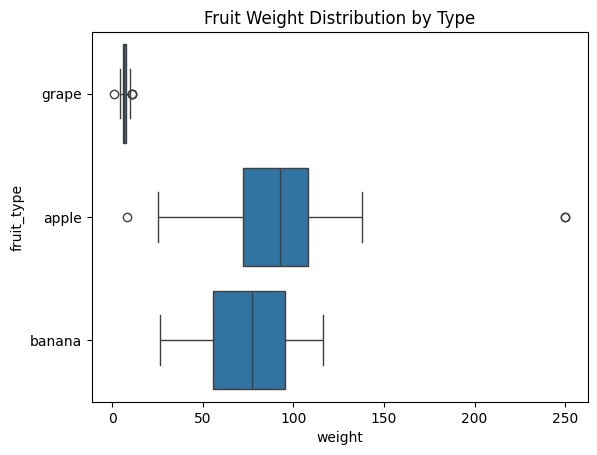

In [11]:
sns.boxplot(x="weight", y="fruit_type", data=df)
plt.title("Fruit Weight Distribution by Type")
plt.show()

In order to find the outliers, the Interquartile Range (IQR) method is used. For this, the difference between the weight at the first quartile (Q1) and at the third quartile (Q3) are calculated. The result multiplied by 1.5 is the limit for finding  outliers in both directions when added or subtracted to the first/third quartile.[1] 
As a result we get a dataframe only containing the possible outliers.

In [12]:
outliers = pd.DataFrame()

# iterate through the fruit types and create a subset for each
for fruit in df['fruit_type'].unique():
    subset = df[df['fruit_type'] == fruit]
    
    # 25th percentile
    Q1 = subset['weight'].quantile(0.25)
    # 75th percentile
    Q3 = subset['weight'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # values below or above 1.5 * Interquartile Range are outliers
    fruit_outliers = subset[
        (subset['weight'] < lower) | (subset['weight'] > upper)
    ]
    
    # If new outliers are found, add them to the dataframe
    outliers = pd.concat([outliers, fruit_outliers])

outliers

,fruit_type,color,size,weight
34,grape,Purple,Tiny,10.902198
37,grape,Yellow,Tiny,1.000000
138,grape,Green,Small,10.902198
192,grape,Green,Medium,10.902198
26,apple,Green,Small,250.000000
33,apple,Yellow,Medium,250.000000
175,apple,Green,Medium,8.300753


A few of the outliers (indices 37, 26, 33) have only zeroes after the decimal point. As this is quite unlikely and they are identified as outliers in the box plot, it is likely that they are measuring errors. A normal, medium sized apple (175) cannot weight 8.3g, making it probably a measuring fault. 
The three unusually heavy grapes (34, 138, 192) could also be measuring errors. Although theoretically, there could be a big grape weighing 10.9g, it is unlikely that there are 'small' and 'tiny' grapes this heavy.  
The medium sized grape weighing 10.9g may be unlikely, but as it is theoretically possible for a grape to weigh this much, there is no information on the type of grape etc. and the deviation is relatively small, it cannot be ruled out and will not be removed from the dataset.
The dataset contains other values that seem unlikely, like a banana weighing 27.7g, that are not identified as outliers using the IQR method, but as there is no other information about the fruit, e.g. if the fruits are fully grown, they will remain in the dataset.

In [13]:
# Index of the medium sized grape weighing 10.9g 
keep_index = [192]

# Get indices of all outliers except the one we want to keep
outliers_index = outliers.index.difference(keep_index)

# Remove the outliers from the dataframe
df_clean = df.drop(index=outliers_index)

Before continuing, the outliers and the cleaned data are saved as excel files, in case they need to be examined later and to make the different steps of data processing visible.

In [14]:
# Remove value that is kept in df_clean
outliers = outliers.drop(index=192)

# Save outliers as excel file
outliers.to_excel('../data/fruit_outliers.xlsx')

# Save cleaned fruit_data as excel file
df_clean.to_excel('../data/fruit_data_clean.xlsx')

# Visualization


### Encoding


# References
[1] ‘Data Preprocessing in Python’, GeeksforGeeks, Oct. 29, 2017. Available: https://www.geeksforgeeks.org/machine-learning/data-preprocessing-machine-learning-python/. [Accessed: Oct. 11, 2025]

